<a href="https://colab.research.google.com/github/TEBATTO/Surface-Crack-Detection/blob/main/Surface_Crack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
arunrk7_surface_crack_detection_path = kagglehub.dataset_download('arunrk7/surface-crack-detection')

print('Data source import complete.')


100%|██████████| 233M/233M [00:05<00:00, 42.7MB/s]

Extracting files...


Data source import complete.


## **Auteur** : TEBATTO ULRICH IROBA
## **Cours : Mathématiques et sciences de données.**  
## **Formation : Master mathématiques appliquées, statistique, Parcours Data Science.**
## **Date** : 20/12/2024
## **Lieu** : Aix-Marseille Université, Marseille, France
## **Projet** : "Surface Crack Detection" : Analyse et Modélisation.

## I. Compréhension du problème

### 1. Contexte

La durabilité des matériaux de construction, tels que le béton, est essentielle pour assurer la sécurité et la longévité des infrastructures. Une des principales causes de détérioration des structures en béton est la formation de fissures, qui peuvent nuire à leur résistance mécanique et permettre l'infiltration d'agents nocifs, tels que l'eau ou les produits chimiques.
Ce projet vise à automatiser la détection de ces fissures à partir d'images, en utilisant des techniques avancées d'analyse d'images et d'apprentissage profond. Cela permettra de faciliter les inspections et de réduire les coûts et les erreurs associés aux évaluations manuelles.

### 2. Jeu de données

Le projet "Détection de fissures de surface" vise à automatiser la détection de fissures sur des matériaux en béton à partir d’images en utilisant des techniques d’apprentissage profond et d’analyse d’images. Le jeu de données utilisé, intitulé Surface Crack Detection et disponible sur Kaggle, comprend des images annotées montrant des surfaces en béton avec ou sans fissures, équilibrées entre ces deux classes. Ces images, de taille 227x227 pixels et en couleur, offrent une base solide pour entraîner des modèles de classification supervisée.

### 3. Objectif

L’objectif principal est de développer une méthode capable d’identifier la présence de fissures avec une précision optimale, tout en assurant une bonne généralisation sur de nouvelles données. Pour ce faire, nous utiliserons une approche moderne, comme les réseaux de neurones convolutifs (CNN). La performance du modèle sera par la suite évaluée à l’aide de métriques standard.

# II. Exploration et Prétraitement des Données

### 1. Bibliothèques et librairies

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

### 2. Charger et Explorer le jeu de données

In [ ]:
# Définir le chemin du dossier de données
chemin_donnees = '../input/surface-crack-detection'

# Obtenir les noms des classes
noms_classes = os.listdir(chemin_donnees)

# Nombre total de classes
nombre_classes = len(noms_classes)

# Liste des fichiers d'images pour chaque classe
fichiers_images = [[os.path.join(chemin_donnees, nom_classe, fichier)
                   for fichier in os.listdir(os.path.join(chemin_donnees, nom_classe))]
                   for nom_classe in noms_classes]


In [ ]:
# Initialiser les listes des fichiers d'images et des étiquettes
liste_fichiers_images = []
liste_etiquettes_images = []

# Parcourir chaque classe pour remplir les listes
for i, nom_classe in enumerate(noms_classes):
    liste_fichiers_images.extend(fichiers_images[i])  # Ajouter les fichiers de la classe
    liste_etiquettes_images.extend([i] * len(fichiers_images[i]))  # Ajouter les étiquettes correspondantes

# Nombre total d'images
nombre_total = len(liste_etiquettes_images)

In [ ]:
# Obtenir les dimensions des images (largeur et hauteur) à partir de la première image
largeur_image, hauteur_image = Image.open(liste_fichiers_images[0]).size

# Afficher les informations sur le dataset
print("Nombre total d'images :", nombre_total)
print("Dimensions des images :", largeur_image, "x", hauteur_image)
print("Noms des classes :", noms_classes)
print("Nombre d'images par classe :", [len(fichiers_images[i]) for i in range(nombre_classes)])


Nombre total d'images : 40000
Dimensions des images : 227 x 227
Noms des classes : ['Negative', 'Positive']
Nombre d'images par classe : [20000, 20000]


Nombre total d'images : 40000
Dimensions des images : (227, 227)
Noms des classes : ['Négative', 'Positive']
Nombre d'images par classe : [20000, 20000]


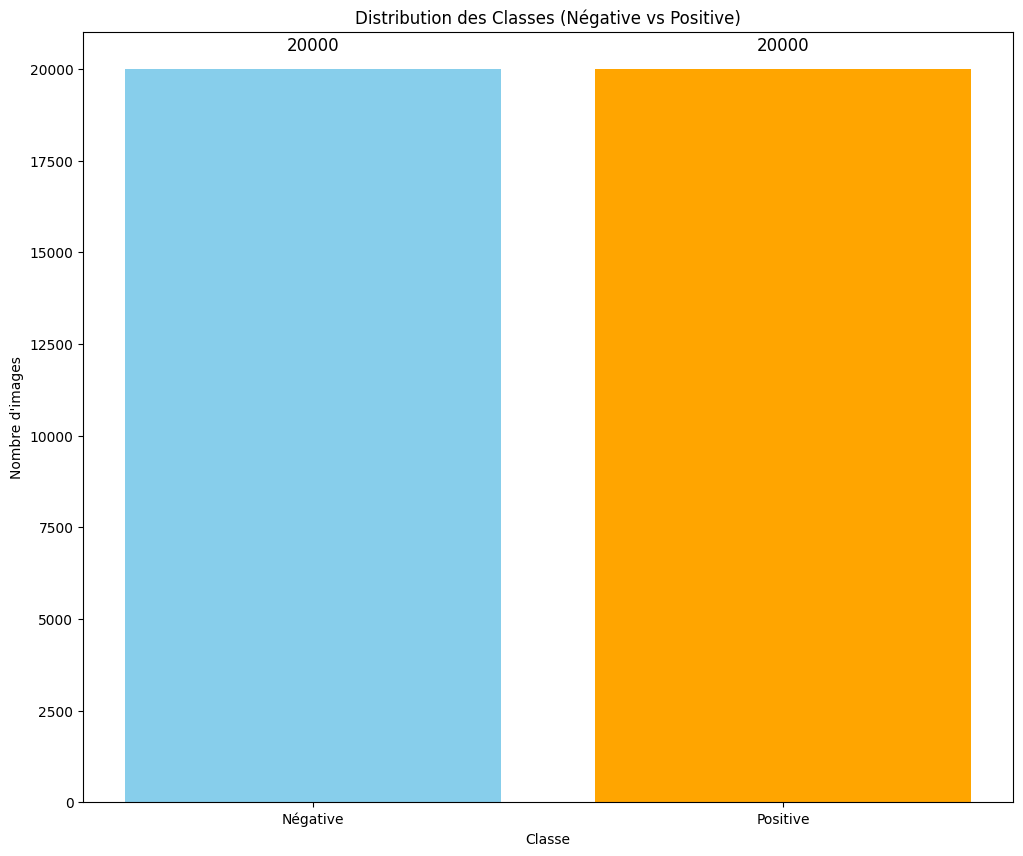

In [ ]:
# Informations sur le dataset
total_images = 40000
dimensions_images = (227, 227)
noms_classes = ['Négative', 'Positive']
nombre_par_classe = [20000, 20000]

# Affichage des informations générales
print(f"Nombre total d'images : {total_images}")
print(f"Dimensions des images : {dimensions_images}")
print(f"Noms des classes : {noms_classes}")
print(f"Nombre d'images par classe : {nombre_par_classe}")

# Visualisation de la distribution des classes
plt.figure(figsize=(12, 10))
plt.bar(noms_classes, nombre_par_classe, color=['skyblue', 'orange'])
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.title("Distribution des Classes (Négative vs Positive)")
for i, count in enumerate(nombre_par_classe):
    plt.text(i, count + 500, str(count), ha='center', fontsize=12)  # Afficher les valeurs au-dessus des barres
plt.show()


### Des exemples pour comprendre la structure des images

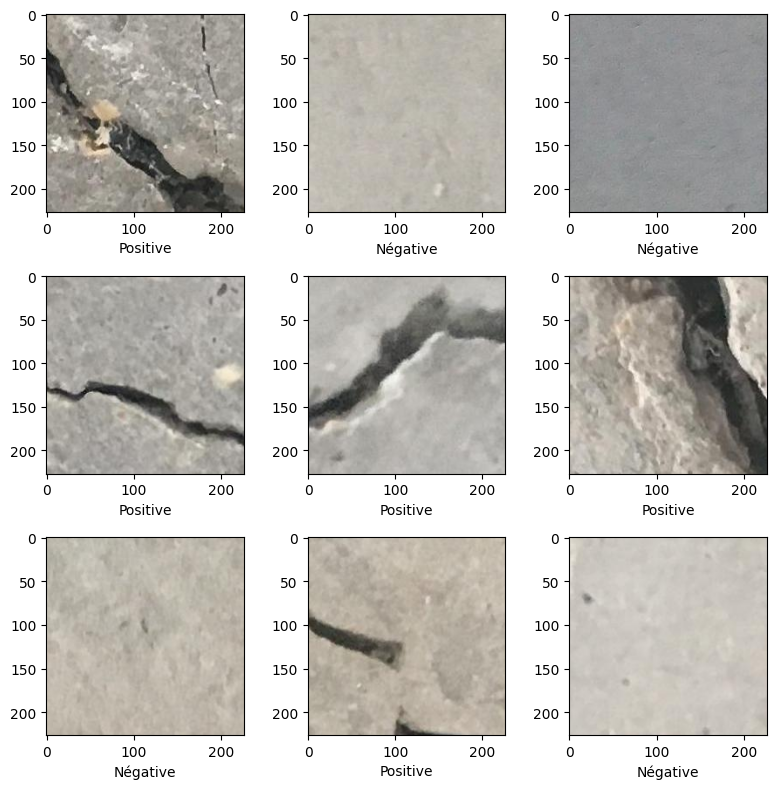

In [ ]:
# Créer une figure avec une grille 3x3
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(nombre_total, size=9)):
    # Charger une image aléatoire
    image = Image.open(liste_fichiers_images[k])
    tableau_image = np.array(image)

    # Afficher l'image dans la sous-figure correspondante
    plt.subplot(3, 3, i + 1)
    plt.xlabel(noms_classes[liste_etiquettes_images[k]])  # Affiche le nom de la classe
    plt.imshow(tableau_image, cmap='gray', vmin=0, vmax=255)

# Ajuster l'affichage
plt.tight_layout()
plt.show()

# III. Entrainement et évaluation

Epoch [1/5] - Train Loss: 0.1079, Val Loss: 0.0406, Train Accuracy: 97.00%
Epoch [2/5] - Train Loss: 0.0351, Val Loss: 0.0329, Train Accuracy: 99.03%
Epoch [3/5] - Train Loss: 0.0231, Val Loss: 0.0170, Train Accuracy: 99.31%
Epoch [4/5] - Train Loss: 0.0150, Val Loss: 0.0191, Train Accuracy: 99.60%
Epoch [5/5] - Train Loss: 0.0112, Val Loss: 0.0324, Train Accuracy: 99.67%
Test Accuracy: 99.35%
F1 Score: 0.9935
Recall: 0.9935

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3000
           1       1.00      0.99      0.99      3000

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



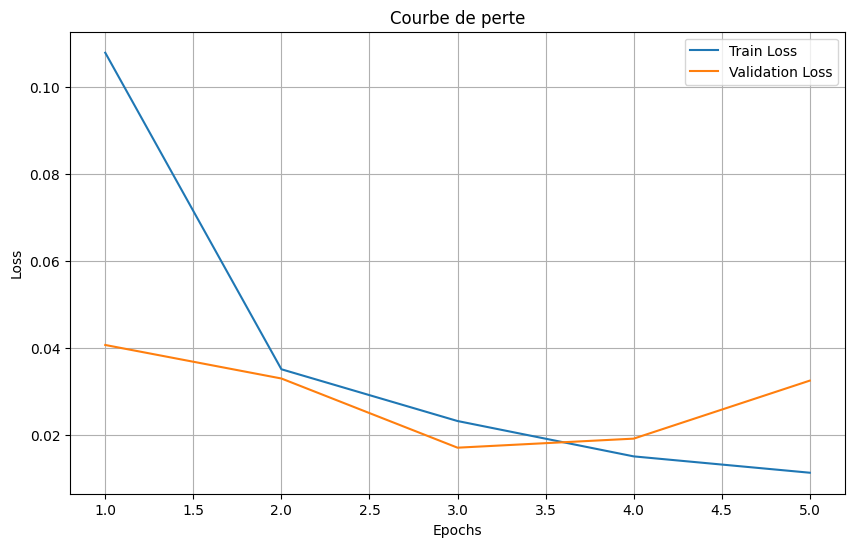

In [ ]:
# 1. Définir le dataset personnalisé
class SurfaceCrackDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 2. Prétraitement des données
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Charger et diviser les données
X_train, X_temp, y_train, y_temp = train_test_split(liste_fichiers_images, liste_etiquettes_images,
                                                    test_size=0.3, stratify=liste_etiquettes_images, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                test_size=0.5, stratify=y_temp, random_state=42)

train_dataset = SurfaceCrackDataset(X_train, y_train, transform=transform)
val_dataset = SurfaceCrackDataset(X_val, y_val, transform=transform)
test_dataset = SurfaceCrackDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 3. Définir un modèle CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)  # 2 classes : Positive et Négative
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialiser le modèle
model = CNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. Configuration de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialisation pour le traçage de la fonction de perte
train_losses = []
val_losses = []

# 5. Entraînement du modèle avec suivi de la perte sur l'ensemble de validation
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

# 6. Évaluation sur le jeu de test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcul des métriques finales
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds))

# Traçage de la courbe de la fonction de perte
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de perte')
plt.legend()
plt.grid(True)
plt.show()

### Analyse de l'évolution des pertes

1. Performance d'entraînement

Train Loss : Diminue progressivement, indiquant que le modèle converge bien vers une solution optimale.
Départ à 0.1079 à la première époque et descend à 0.0112 à la cinquième époque.
Train Accuracy : Atteint une précision impressionnante de 99.67% à la fin de l'entraînement.

2. Performance de la validation
Val Loss : Diminue initialement mais montre une légère augmentation à partir de l'époque 4 (0.0191) jusqu'à l'époque 5 (0.0324). Cela peut être un signe de légère surapprentissage.
Test Accuracy : Très élevée à 99.35%, montrant une excellente généralisation du modèle.


3.Comportement entre l'entraînement et la validation
La perte d'entraînement continue de diminuer de manière constante, tandis que la perte de validation stagne ou augmente après l'époque 3. Cela indique que le modèle atteint un point où il s'ajuste trop étroitement aux données d'entraînement, ce qui réduit sa capacité à généraliser aux nouvelles données.




4. Métriques d'évaluation
    - F1 Score : 0.9935, ce qui est excellent, surtout pour des données où l'équilibre des classes est critique.
    - Recall : Identique au F1-score (0.9935), indiquant que le modèle détecte efficacement toutes les classes sans laisser d'exemples de côté.


### Analyse du Rapport de Classification

1. Par classe :
Classe 0 (Negative) :

Précision : 0.99
Indique que 99% des prédictions pour la classe 0 sont correctes.
Rappel : 1.00
Cela signifie que toutes les instances de la classe 0 ont été correctement identifiées.
F1-Score : 0.99
Reflète un bon équilibre entre précision et rappel.

Classe 1 (Positive) :

Précision : 1.00
Toutes les prédictions pour la classe 1 sont correctes.
Rappel : 0.99
Une très petite proportion d'instances de la classe 1 a été manquée.
F1-Score : 0.99
Montre également un excellent équilibre entre précision et rappel.

2. Globalement :
Accuracy : 0.99 (99%)
Indique que le modèle a correctement classé 99% de l'ensemble des données de test.

Interprétation des résultats
Le modèle gère bien les deux classes, avec une précision élevée et un rappel presque parfait.
Le F1-Score de 0.99 indique que le modèle fonctionne très bien, même en équilibrant les faux positifs et les faux négatifs.

Les résultats sont très satisfaisants pour un problème de classification binaire, avec peu d'erreurs visibles.


### Conclusion

Le modèle de classification des fissures de surface atteint des performances remarquables avec une précision de 99.35% sur le jeu de test, un F1-Score et un rappel de 0.9935, démontrant une excellente capacité de généralisation. Les courbes d'entraînement montrent une convergence rapide, mais une légère augmentation de la perte de validation après l'époque 3 indique un début de surapprentissage. Le rapport de classification confirme un équilibre parfait entre les classes, avec des métriques uniformes pour les deux catégories. Bien que le modèle soit efficace, des améliorations comme l'augmentation des données, l'arrêt anticipé ou une régularisation accrue pourraient renforcer sa robustesse. Globalement, ce projet est une réussite, illustrant la puissance des CNN pour la classification d'images.